# Dataset Information
- Competition: https://www.kaggle.com/competitions/playground-series-s4e2/overview
- Origin Dataset: https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster
- Interesting: https://rstudio-pubs-static.s3.amazonaws.com/872760_24a044829eda4ba68996628b3a9efb06.html


- FAVC - Frequent consumption of high caloric food
- FCVC - Frequency of consumption of vegetables
- NCP - Number of main meals
- CAEC - Consumption of food between meals
- CH20 - Consumption of water daily
- SCC - Calories consumption monitoring
- FAF - Physical activity frequency
- TUE - Time using technology devices 
- CALC - Consumption of alcohol
- MTRANS - Transportation used    


NObesity values are:
- Insufficient_Weight Less than 18.5
- Normal_Weight 18.5 to 24.9
- Overweight_Level_I 25.0 to 29.9
- Overweight_Level_II I 30.0 to 34.9
- Obesity_Type_I II 35.0 to 39.9
- Obesity_Type_II more than 40

# Goal of the  of this competition
To use various factors to predict obesity risk in individuals, which is related to cardiovascular disease. Good luck!

# Submission Goal
Estimate NObeyesdad for every id.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder ,OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_selector

In [2]:
# Load the data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_submission = pd.read_csv("sample_submission.csv")
# Load data from other dataset 
df_obesity = pd.read_csv("ObesityDataSet.csv") # Original data 
#df_train = pd.concat([df_train, df_obesity], axis =0)  # axis = 0 , needed for function concat, connect theses dataframes vertically together
#df_train = df_train.drop_duplicates()
#display(df_train.shape, df_train.head(), df_train.describe(include=[np.number]).T, df_train.describe(include=[object]).T, df_train.isna().sum())

First thoughts about the dataset:
- Age is Min 14 years old and max is 61
- Sex is Male and Female
- Height 145cm - 197 cm
- Weight 39kg - 165kg

In [77]:
df_obesity.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [7]:
df_obesity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [5]:
df_train = df_train.drop(['id'], axis=1)
pd.set_option('display.max_columns', None)
df_train.head(50)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II
5,Male,18.128249,1.748524,51.552595,yes,yes,2.919751,3.000000,Sometimes,no,2.137550,no,1.930033,1.000000,Sometimes,Public_Transportation,Insufficient_Weight
6,Male,29.883021,1.754711,112.725005,yes,yes,1.991240,3.000000,Sometimes,no,2.000000,no,0.000000,0.696948,Sometimes,Automobile,Obesity_Type_II
7,Male,29.891473,1.750150,118.206565,yes,yes,1.397468,3.000000,Sometimes,no,2.000000,no,0.598655,0.000000,Sometimes,Automobile,Obesity_Type_II
8,Male,17.000000,1.700000,70.000000,no,yes,2.000000,3.000000,Sometimes,no,3.000000,yes,1.000000,1.000000,no,Public_Transportation,Overweight_Level_I
9,Female,26.000000,1.638836,111.275646,yes,yes,3.000000,3.000000,Sometimes,no,2.632253,no,0.000000,0.218645,Sometimes,Public_Transportation,Obesity_Type_III


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF                             

In [12]:
merge = [df_train, df_obesity]
df_train = pd.concat(merge)

In [13]:
df_train.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22869 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          22869 non-null  object 
 1   Age                             22869 non-null  float64
 2   Height                          22869 non-null  float64
 3   Weight                          22869 non-null  float64
 4   family_history_with_overweight  22869 non-null  object 
 5   FAVC                            22869 non-null  object 
 6   FCVC                            22869 non-null  float64
 7   NCP                             22869 non-null  float64
 8   CAEC                            22869 non-null  object 
 9   SMOKE                           22869 non-null  object 
 10  CH2O                            22869 non-null  float64
 11  SCC                             22869 non-null  object 
 12  FAF                             22869 

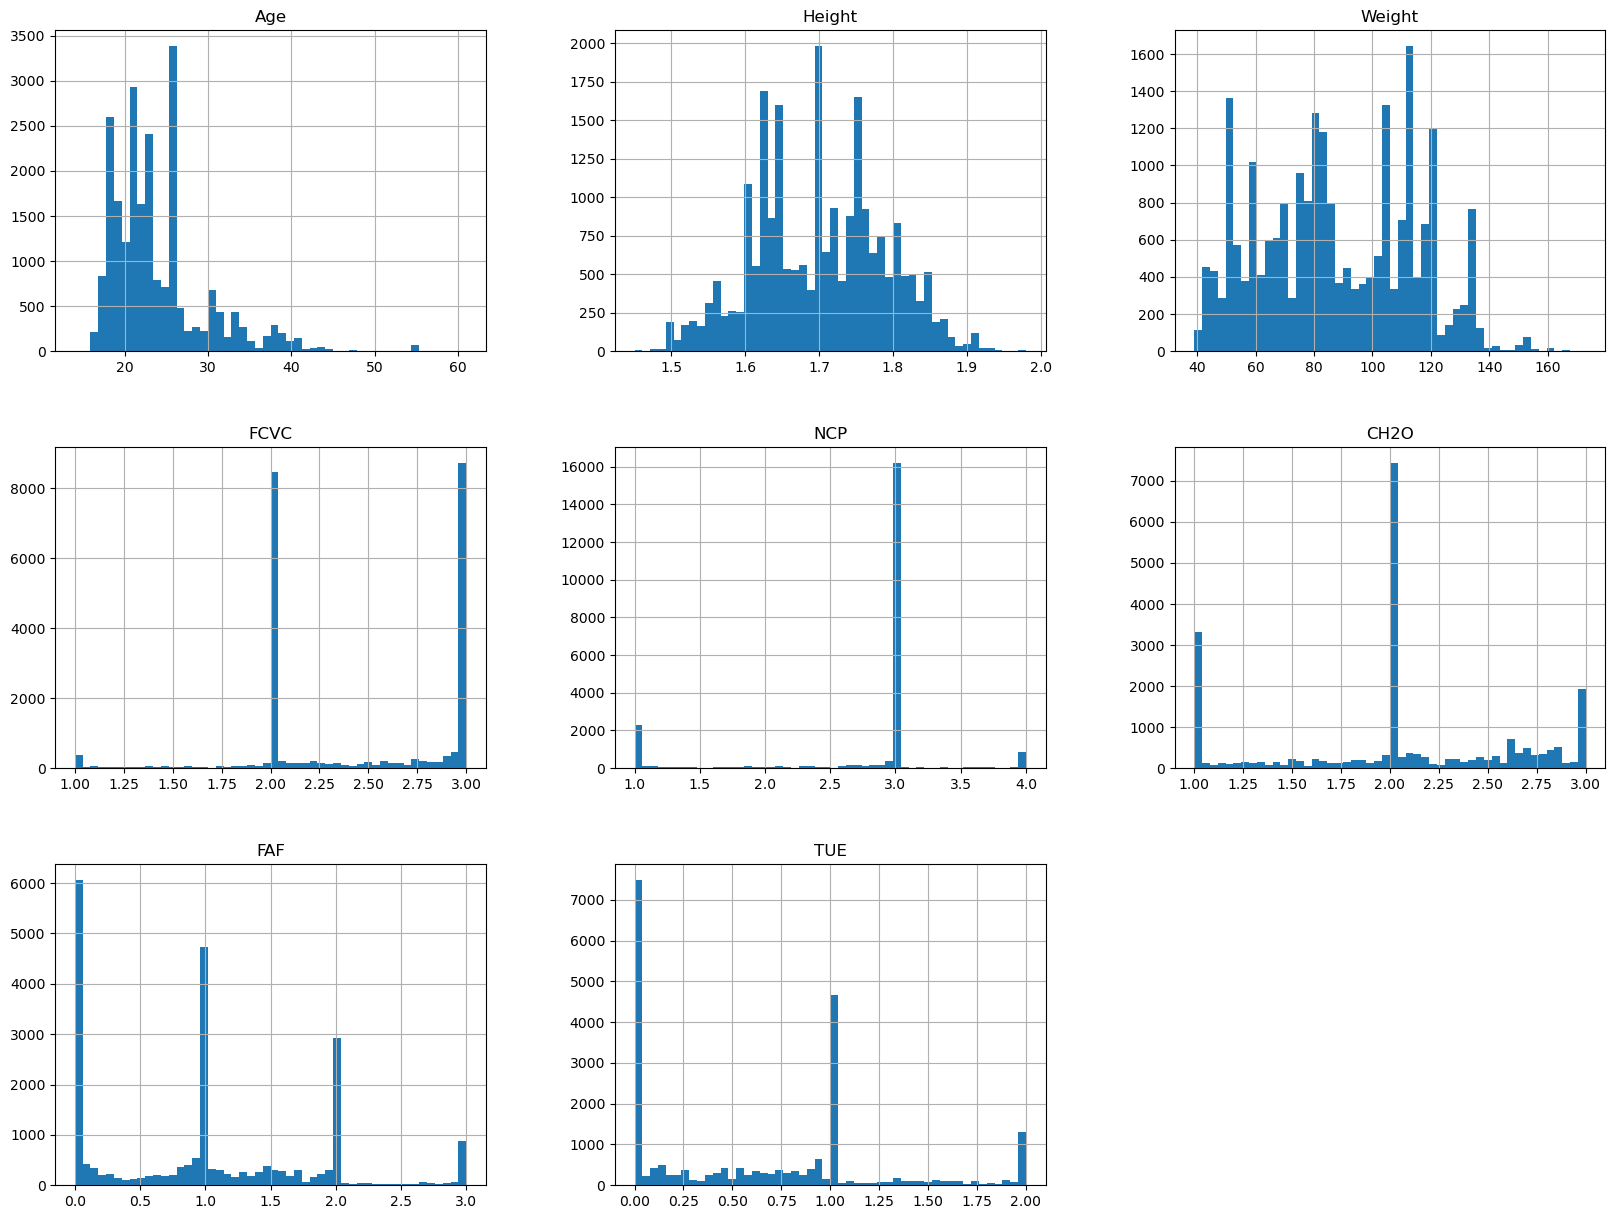

In [15]:
df_train.hist(bins=50, figsize=(20,15))
plt.show()

Feature Age could be scaled because of the slight left shift.

In [16]:
df_train.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000
mean,23.885263,1.700377,87.767610,2.443428,2.754344,2.027442,0.984382,0.620551
std,5.753419,0.087881,26.364243,0.533329,0.712711,0.608901,0.839466,0.602850
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.631662,66.000000,2.000000,3.000000,1.755907,0.015860,0.000000
50%,22.815416,1.700000,84.000000,2.392665,3.000000,2.000000,1.000000,0.579541
75%,26.000000,1.763029,111.531208,3.000000,3.000000,2.535127,1.596576,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


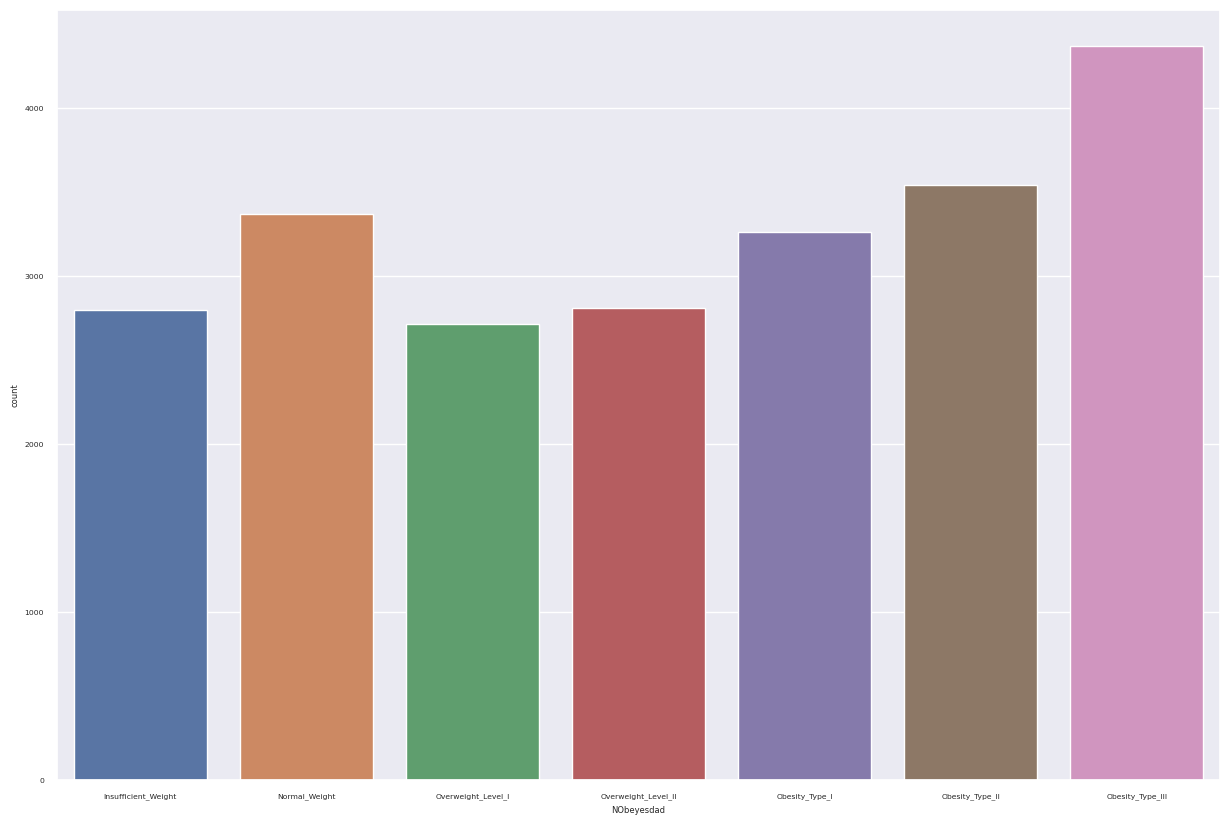

In [17]:
sns.set(font_scale=0.5)
plt.figure(figsize=(15, 10))
NObeyesdad_order= ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II' ,'Obesity_Type_III'] 
sns.countplot(data = df_train, x='NObeyesdad',order= NObeyesdad_order ) # There are not all even.
plt.show()

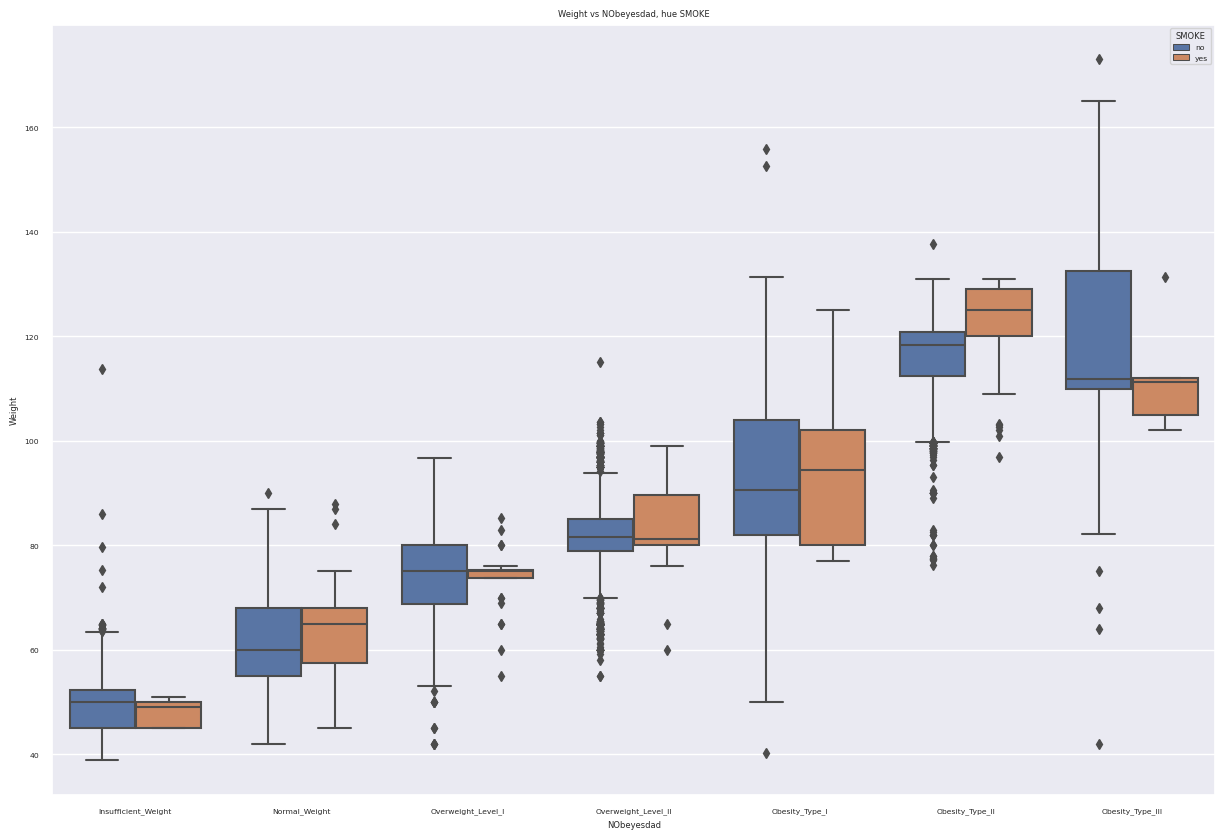

In [18]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=0.5)
sns.boxplot(data = df_train, y="Weight", x="NObeyesdad", hue="SMOKE", order=NObeyesdad_order)
plt.title("Weight vs NObeyesdad, hue SMOKE")
plt.show()

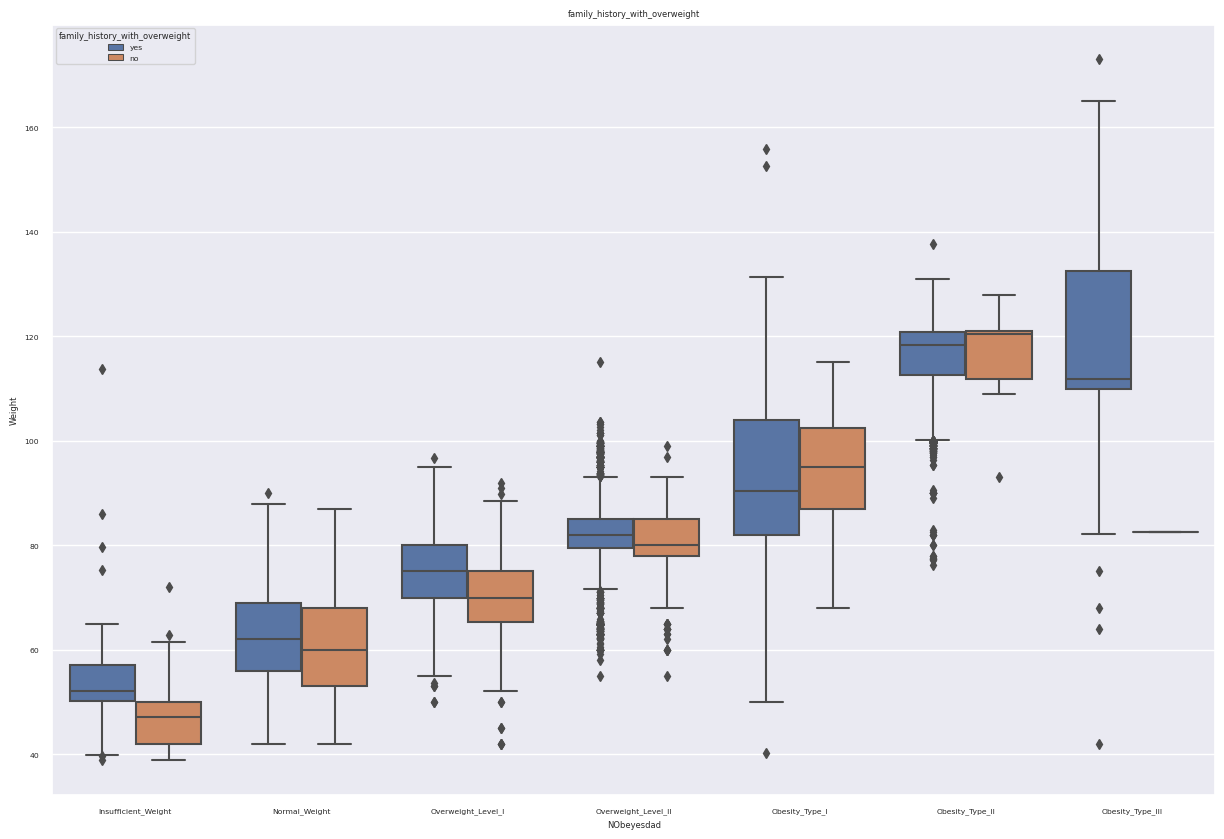

In [19]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=0.5)
sns.boxplot(data = df_train, y="Weight", x="NObeyesdad", hue="family_history_with_overweight", order=NObeyesdad_order)
plt.title("family_history_with_overweight")
plt.show()

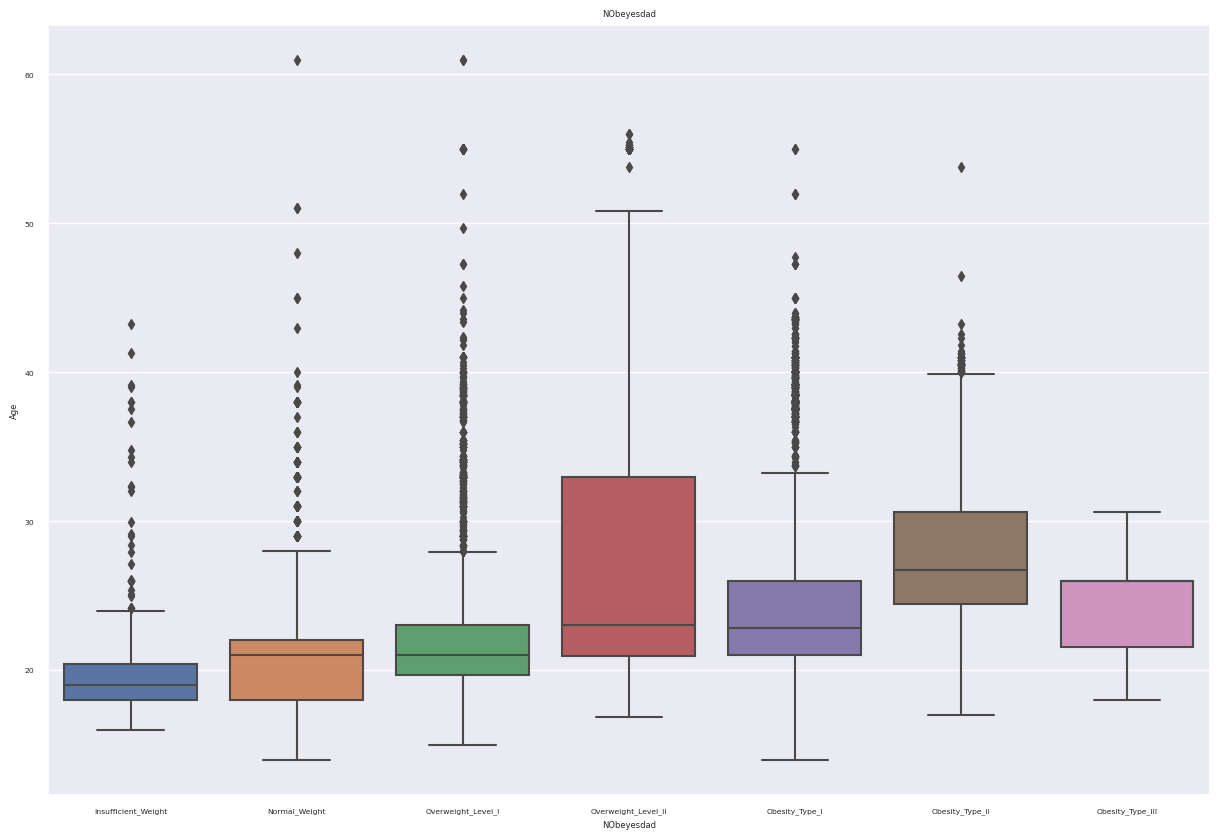

In [20]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=0.5)
sns.boxplot(data = df_train, y="Age", x="NObeyesdad", order=NObeyesdad_order)
plt.title("NObeyesdad")
plt.show()

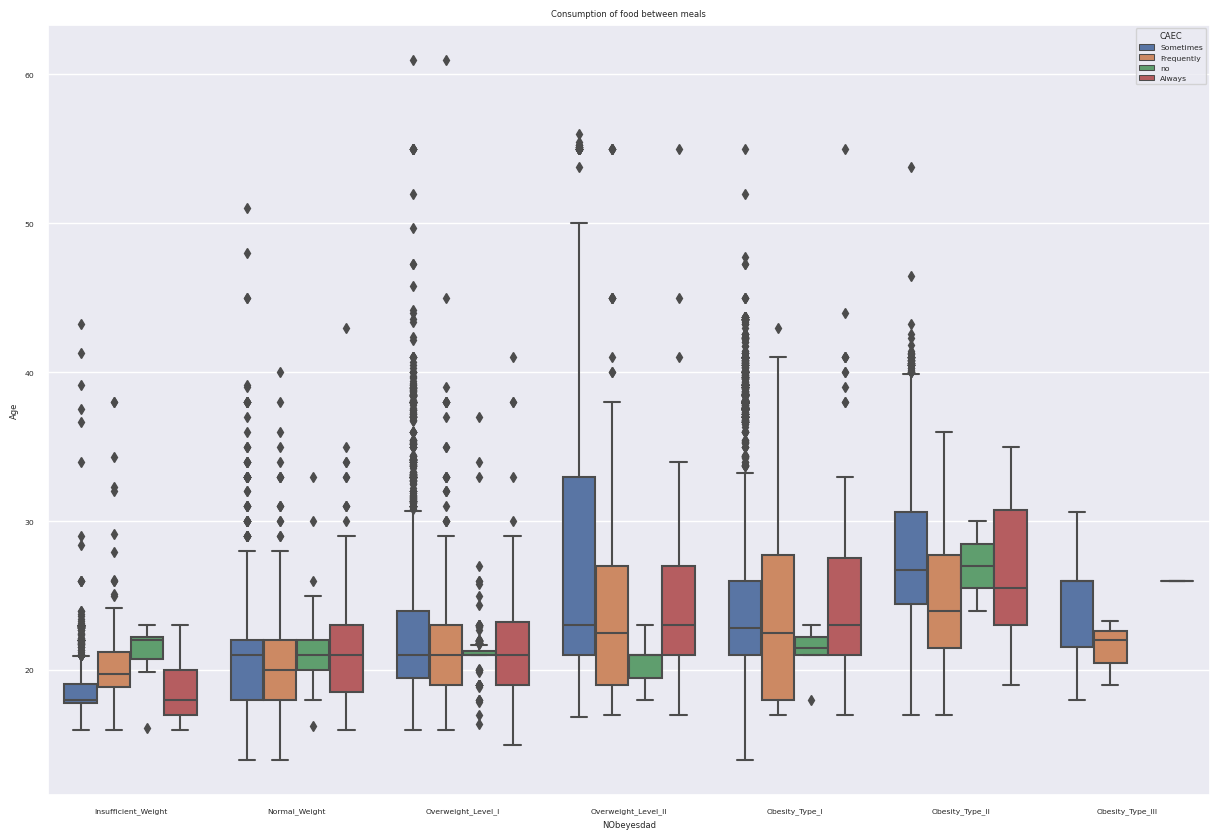

In [89]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=0.5)
sns.boxplot(data = df_train, y="Age", x="NObeyesdad", hue="CAEC", order=NObeyesdad_order)
plt.title("Consumption of food between meals")
plt.show()

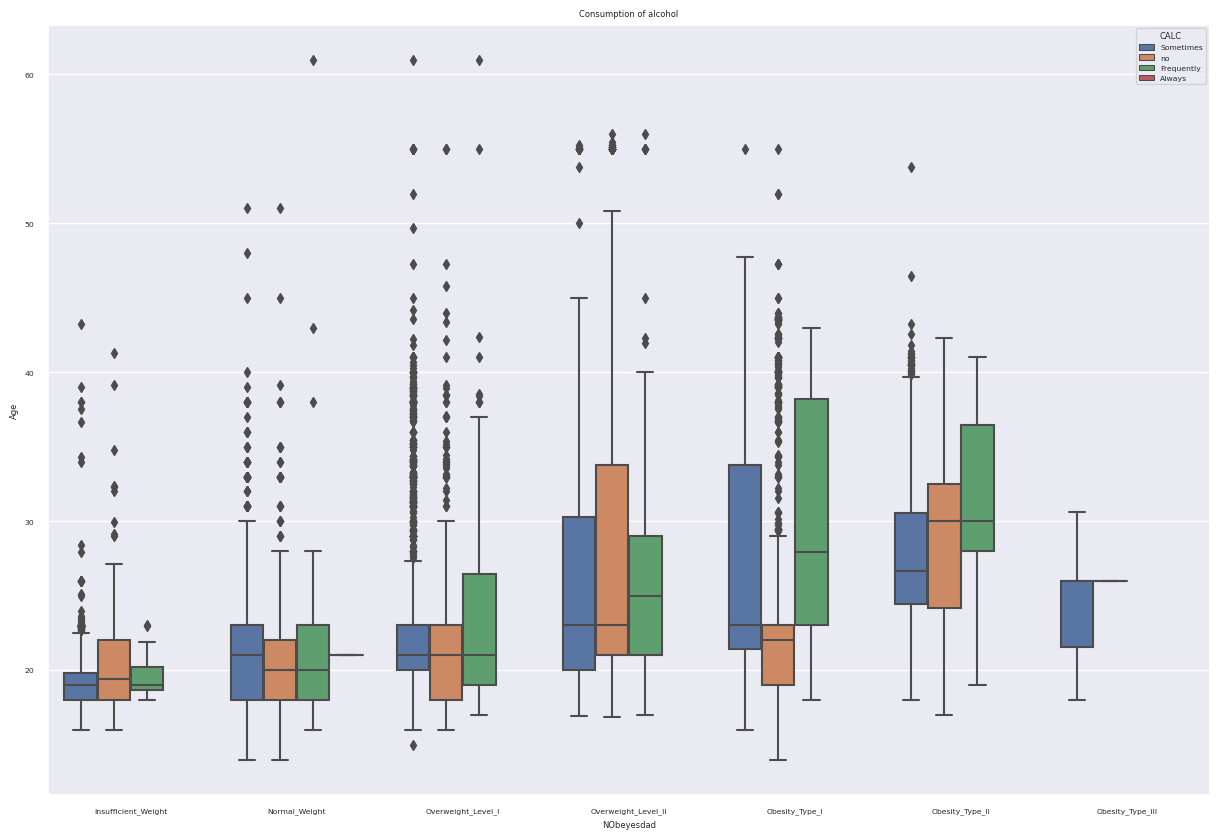

In [21]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=0.5)
sns.boxplot(data = df_train, y="Age", x="NObeyesdad", hue="CALC", order=NObeyesdad_order)
plt.title("Consumption of alcohol")
plt.show()

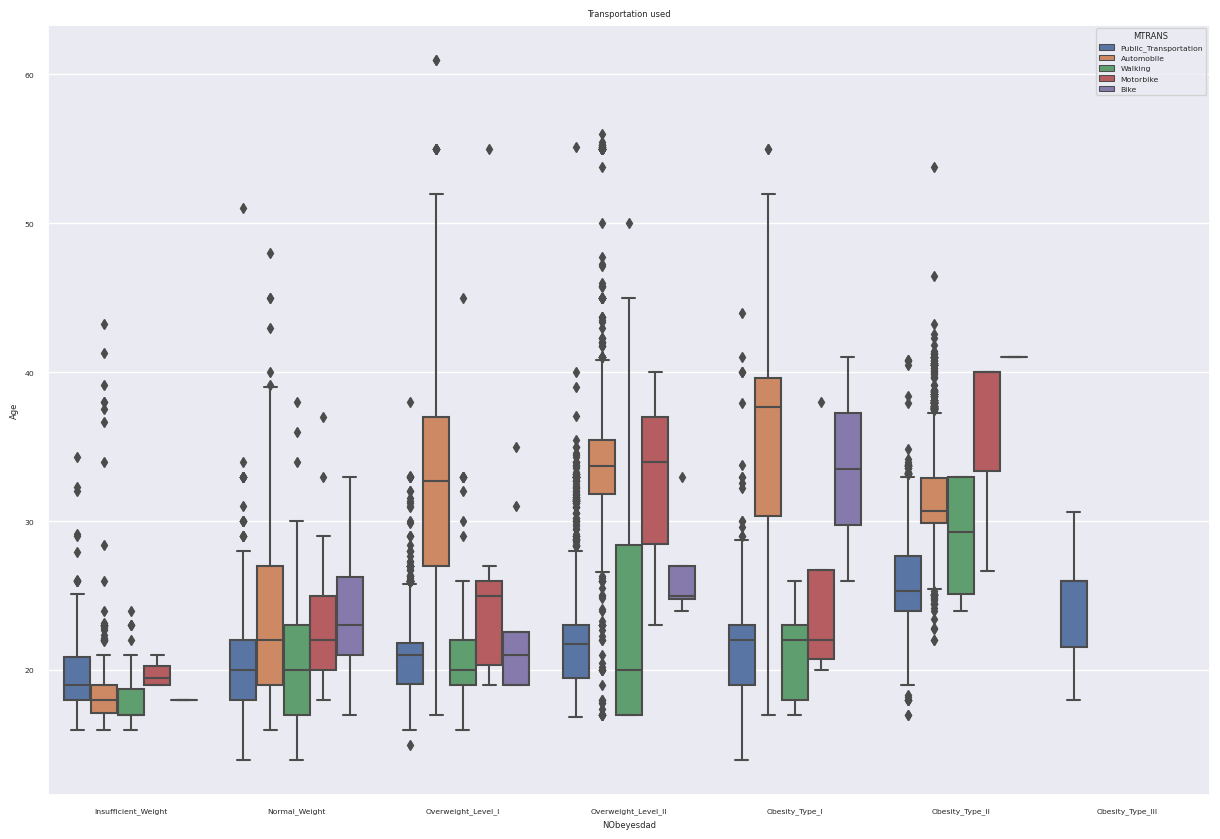

In [91]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=0.5)
sns.boxplot(data = df_train, y="Age", x="NObeyesdad", hue="MTRANS", order=NObeyesdad_order)
plt.title("Transportation used")
plt.show()

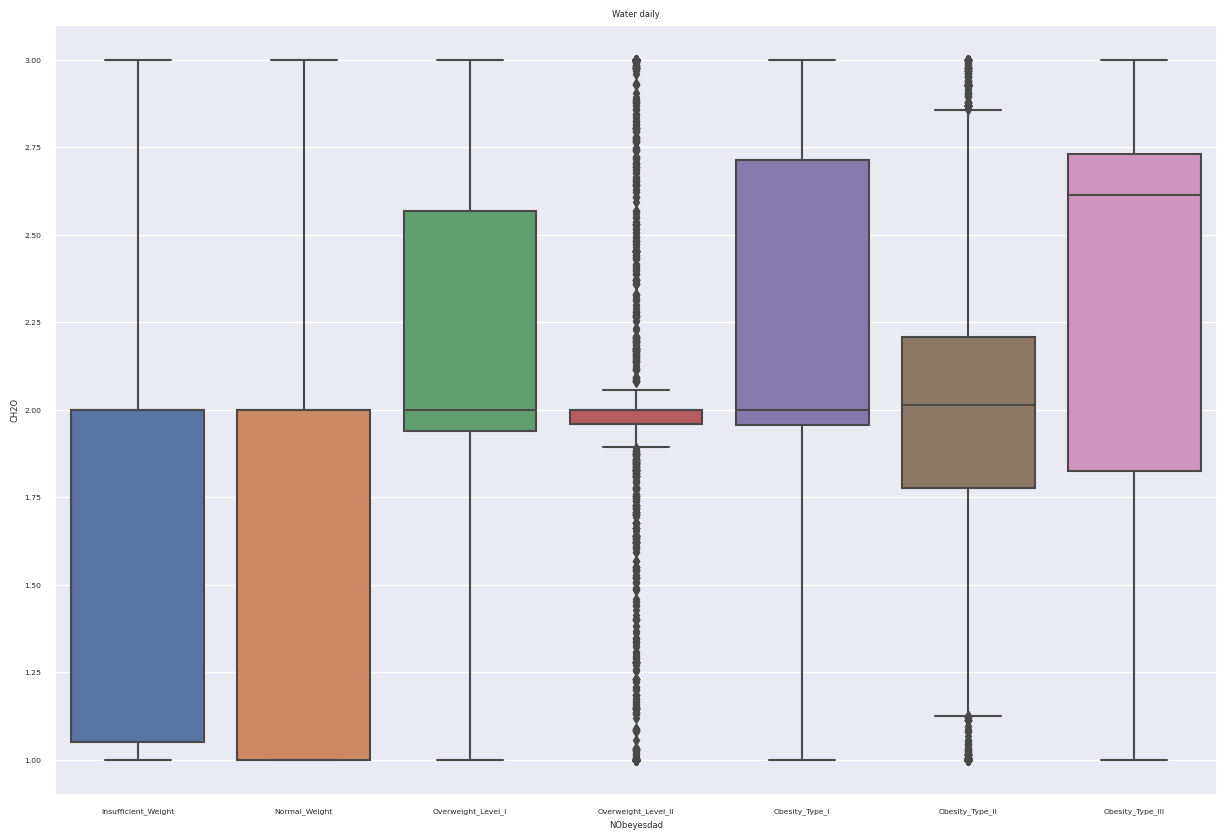

In [22]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=0.5)
sns.boxplot(data = df_train, y="CH2O", x="NObeyesdad", order=NObeyesdad_order)
plt.title("Water daily")
plt.show()


# Corr Matrix

There are a high correlation to nObeyesdad:
- Age 
- Weight
- family_history_with_overweight
- CAEC, Consumption of foods between meals
- CH2O, Consumption of water daily (Not so much like the other)

In [35]:
corr_mat = df_train.corr
sns.heatmap(corr_mat, annot=True, fmt=".2f", cmap='coolwarm')
#plt.show()

ValueError: Must pass 2-d input. shape=()

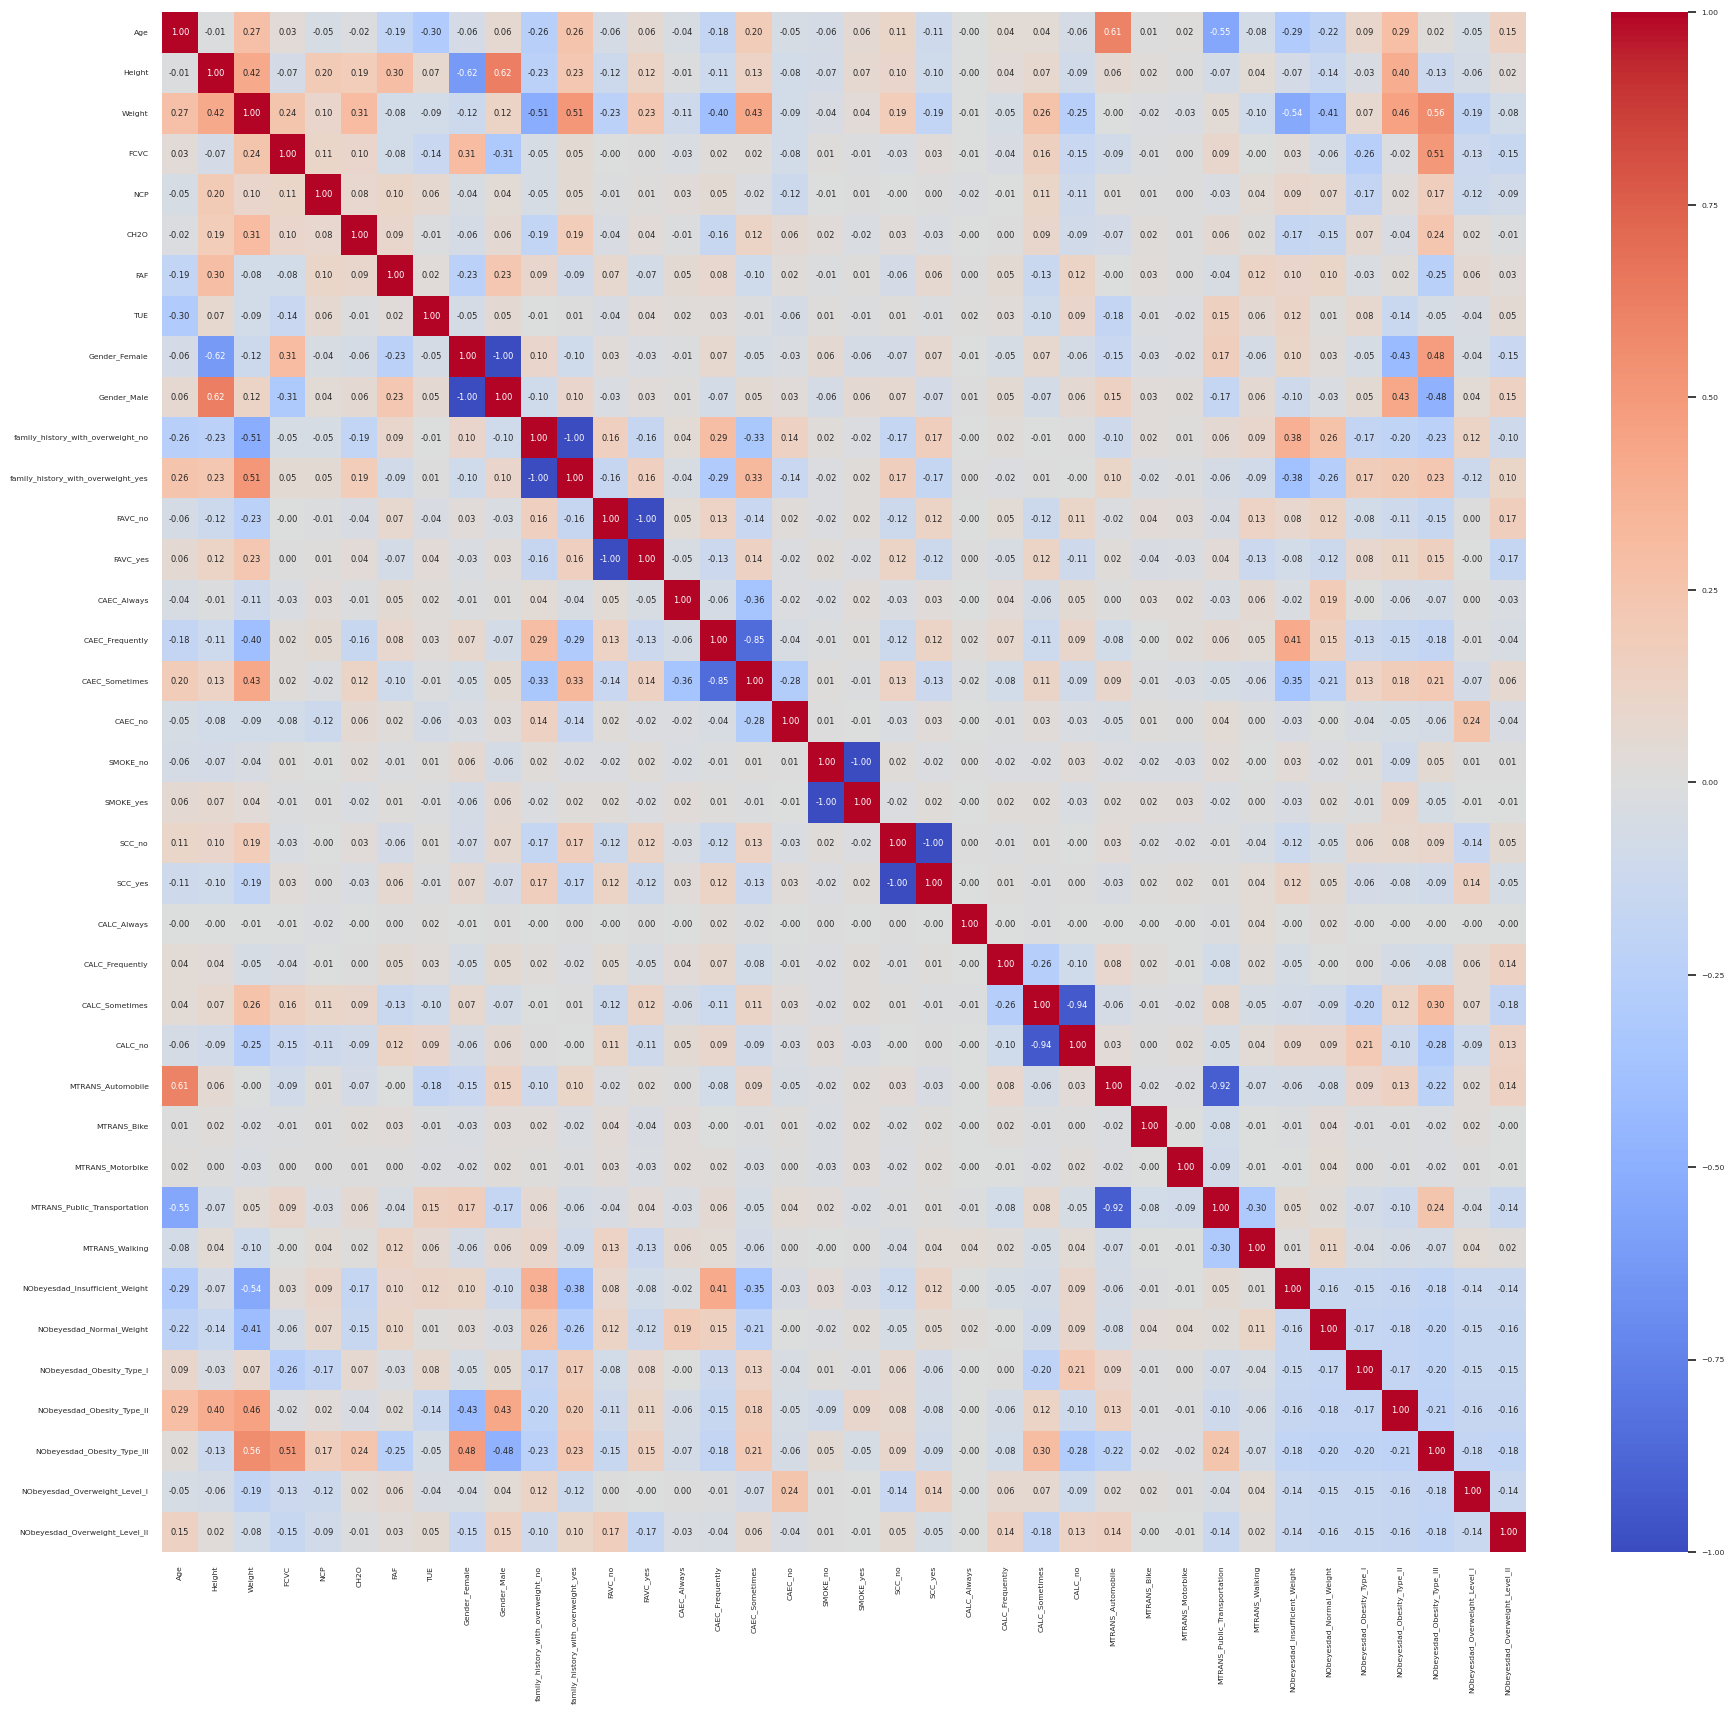

In [23]:
# big correlation matrix 
df_with_dummies = pd.get_dummies(df_train, columns=['Gender','family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad'])
corr_with_dummies = df_with_dummies.corr()
plt.figure(figsize=(22 , 20))
sns.heatmap(corr_with_dummies, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

# Data Cleaning

In [36]:
df_train.isnull().sum() # no missing values

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [37]:
df_train[df_train.duplicated(keep='first')]

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
98,Female,21.0,1.52,42.0,no,no,3.0,1.0,Frequently,no,1.0,no,0.0,0.0,Sometimes,Public_Transportation,Insufficient_Weight
106,Female,25.0,1.57,55.0,no,yes,2.0,1.0,Sometimes,no,2.0,no,2.0,0.0,Sometimes,Public_Transportation,Normal_Weight
174,Male,21.0,1.62,70.0,no,yes,2.0,1.0,no,no,3.0,no,1.0,0.0,Sometimes,Public_Transportation,Overweight_Level_I
179,Male,21.0,1.62,70.0,no,yes,2.0,1.0,no,no,3.0,no,1.0,0.0,Sometimes,Public_Transportation,Overweight_Level_I
184,Male,21.0,1.62,70.0,no,yes,2.0,1.0,no,no,3.0,no,1.0,0.0,Sometimes,Public_Transportation,Overweight_Level_I
209,Female,22.0,1.69,65.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Sometimes,Public_Transportation,Normal_Weight
309,Female,16.0,1.66,58.0,no,no,2.0,1.0,Sometimes,no,1.0,no,0.0,1.0,no,Walking,Normal_Weight
460,Female,18.0,1.62,55.0,yes,yes,2.0,3.0,Frequently,no,1.0,no,1.0,1.0,no,Public_Transportation,Normal_Weight
467,Male,22.0,1.74,75.0,yes,yes,3.0,3.0,Frequently,no,1.0,no,1.0,0.0,no,Automobile,Normal_Weight
496,Male,18.0,1.72,53.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,2.0,Sometimes,Public_Transportation,Insufficient_Weight


# Preprocessing

In [38]:
X_train, y_train = df_train.drop("NObeyesdad", axis=1), df_train["NObeyesdad"]
X_test = df_test

# Model selection

In [39]:
# Annahme: Sie haben bereits Ihre Daten geladen und vorverarbeitet
# X enthält die Features und y die entsprechenden Labels

# Definieren der Spaltennamen für kategorische und numerische Features
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC']
numerical_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

# Aufteilen der Daten in Trainings- und Testsets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definieren der Pipelines für die Transformationen
categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Kombinieren der Pipelines mit ColumnTransformer
preprocessor = ColumnTransformer([
    ('cat', categorical_pipeline, categorical_features),
    ('num', numerical_pipeline, numerical_features)
])

In [42]:
# Zusammenstellen des gesamten Pipelines für Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Hyperparameter-Raster für den Random Forest
rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
}

# GridSearchCV für den Random Forest
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=2, n_jobs=-1)

# Trainieren des Random Forest Modells mit Cross-Validation
rf_grid_search.fit(X_train, y_train)

# Beste Parameter und beste Genauigkeit des Random Forest
print("Beste Parameter für Random Forest:", rf_grid_search.best_params_)
print("Beste Genauigkeit für Random Forest:", rf_grid_search.best_score_)

# Vorhersagen für den Testdatensatz mit Random Forest
rf_predictions = rf_grid_search.predict(X_test)

# Ausgabe der Vorhersagen für Random Forest
print("Random Forest Vorhersagen:", rf_predictions)

# Cross-Validation-Vorhersagen für RF
rf_predictions_encoded_cv = cross_val_predict(rf_grid_search.best_estimator_, X_train, y_train, cv=3)

# Ausgabe der Vorhersagen für Random Forest
print("RF Vorhersagen (Cross-Validation):", rf_predictions_encoded_cv)

# Fehleranalyse für RF basierend auf Cross-Validation
print("\nFehleranalyse für RF (Cross-Validation):")
print(classification_report(y_train, rf_predictions_encoded_cv))

# Confusion Matrix für RF basierend auf Cross-Validation
conf_matrix_cv = confusion_matrix(y_train, rf_predictions_encoded_cv)

# Ausgabe der Confusion Matrix
print("\nConfusion Matrix für RF (Cross-Validation):")
print(conf_matrix_cv)

Beste Parameter für Random Forest: {'classifier__max_depth': 20, 'classifier__n_estimators': 200}
Beste Genauigkeit für Random Forest: 0.8953171560299413
Random Forest Vorhersagen: ['Obesity_Type_II' 'Overweight_Level_I' 'Obesity_Type_III' ...
 'Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_II']
RF Vorhersagen (Cross-Validation): ['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight' ...
 'Obesity_Type_III' 'Obesity_Type_III' 'Obesity_Type_III']

Fehleranalyse für RF (Cross-Validation):
                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.92      0.93      2795
      Normal_Weight       0.83      0.89      0.86      3369
     Obesity_Type_I       0.90      0.88      0.89      3261
    Obesity_Type_II       0.97      0.97      0.97      3545
   Obesity_Type_III       1.00      1.00      1.00      4370
 Overweight_Level_I       0.81      0.73      0.77      2717
Overweight_Level_II       0.78      0.83      0.80      2812

       

In [43]:
# Kodieren der Klassenlabels für XGBoost
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Zusammenstellen des gesamten Pipelines für XGBoost
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier())
])

# Hyperparameter-Raster für XGBoost
xgb_param_grid = {
    'classifier__n_estimators': [800, 900, 1000],
    'classifier__max_depth': [4],
    'classifier__learning_rate': [0.05, 0.1],  # Hinzufügen von Lernraten
    'classifier__subsample': [0.8, 0.9],  # Stichprobengröße für Bootstrapping
    'classifier__colsample_bytree': [0.5, 0.6]  # Feature-Subsampling-Rate pro Baum
}

# GridSearchCV für XGBoost
xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=2, n_jobs=-1)

# Trainieren des XGBoost-Modells mit Cross-Validation
xgb_grid_search.fit(X_train, y_train_encoded)

# Beste Parameter und beste Genauigkeit für XGBoost
print("\nBeste Parameter für XGBoost:", xgb_grid_search.best_params_)
print("Beste Genauigkeit für XGBoost:", xgb_grid_search.best_score_)

# Cross-Validation-Vorhersagen für XGBoost
xgb_predictions_encoded_cv = cross_val_predict(xgb_grid_search.best_estimator_, X_train, y_train_encoded, cv=2)

# Dekodieren der Vorhersagen für XGBoost
xgb_predictions_cv = label_encoder.inverse_transform(xgb_predictions_encoded_cv)

# Ausgabe der Vorhersagen für XGBoost
print("XGBoost Vorhersagen (Cross-Validation):", xgb_predictions_cv)

# Fehleranalyse für XGBoost basierend auf Cross-Validation
print("\nFehleranalyse für XGBoost (Cross-Validation):")
print(classification_report(y_train, xgb_predictions_cv))

# Confusion Matrix für XGBoost basierend auf Cross-Validation
conf_matrix_cv = confusion_matrix(y_train, xgb_predictions_cv)

# Ausgabe der Confusion Matrix
print("\nConfusion Matrix für XGBoost (Cross-Validation):")
print(conf_matrix_cv)

prediction_X_test = xgb_grid_search.predict(X_test)
prediction_X_test = xgb_grid_search.predict(prediction_X_test)
prediction_X_test_encoded = label_encoder.inverse_transform(prediction_X_test)


Beste Parameter für XGBoost: {'classifier__colsample_bytree': 0.5, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 4, 'classifier__n_estimators': 800, 'classifier__subsample': 0.8}
Beste Genauigkeit für XGBoost: 0.9098345218684003
XGBoost Vorhersagen (Cross-Validation): ['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight' ...
 'Obesity_Type_III' 'Obesity_Type_III' 'Obesity_Type_III']

Fehleranalyse für XGBoost (Cross-Validation):
                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.94      0.94      2795
      Normal_Weight       0.87      0.89      0.88      3369
     Obesity_Type_I       0.90      0.89      0.90      3261
    Obesity_Type_II       0.96      0.97      0.97      3545
   Obesity_Type_III       1.00      1.00      1.00      4370
 Overweight_Level_I       0.81      0.78      0.80      2717
Overweight_Level_II       0.82      0.83      0.82      2812

           accuracy                           0.91     

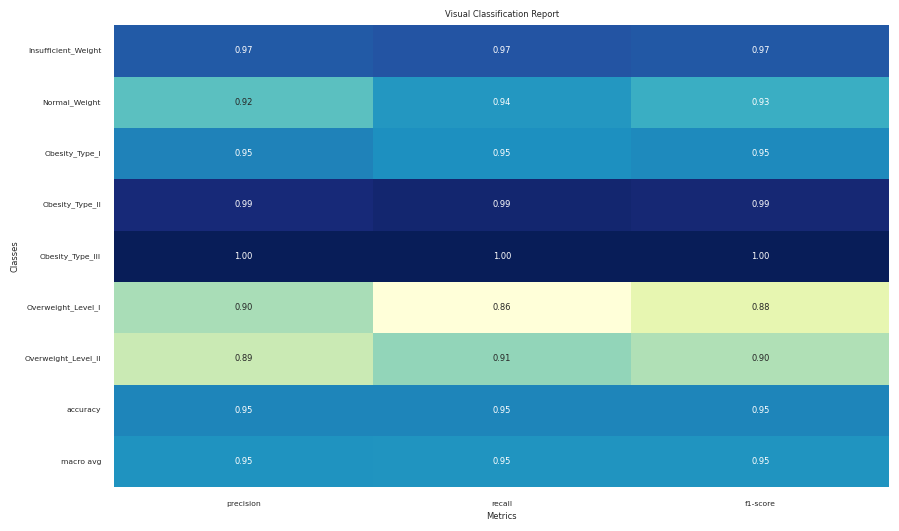

In [60]:
# Vorhersagen für den Trainingsdatensatz
xgb_predictions_encoded = xgb_grid_search.predict(X_train)
xgb_predictions = label_encoder.inverse_transform(xgb_predictions_encoded)

# Klassifikationsbericht erstellen
report = classification_report(y_train, xgb_predictions, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Plot des Klassifikationsberichts
plt.figure(figsize=(10, 6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f", cbar=False)
plt.title('Visual Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()

In [ ]:
print(prediction_X_test_encoded)
df_submission['NObeyesdad'] = prediction_X_test_encoded
df_submission.to_csv('submission.csv', index=False)